# <p><a name="sections"></a></p>


# Sections
- <a href="#basic">Basic Help and Information</a><br>
- <a href="#func">User Defined Function</a><br>
- <a href="#explore">Explore Results & Combine</a><br>
- <a href="#clean">Clean the Data</a><br>
- <a href="#stats1">Descriptive Statistics</a><br>
- <a href="#filter1">Filter (subset) the Data</a><br>
- <a href="#company">Bucketing Results & Analyzing</a><br>
- <a href="#timeout"><font color=green>Timeout for Data Dump </font></a><br>

- <a href="#viz1">Salary Histograms</a><br>
- <a href="#addl">Additional Analyses</a><br>
- <a href="#end">End</a><br>

In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import warnings

warnings.filterwarnings('ignore')   #hide sloppy coding :)
plt.style.use('fivethirtyeight')

##### Website to scrape
http://h1bdata.info

<p><a name="func"></a></p>
### Function to read table on website

In [2]:
def collect_tables(target):
    # access website, populate form, get results as html
    url = "http://h1bdata.info/index.php?em={}".format(target)
    content = requests.get(url).text
    
    #process the html code
    soup = BeautifulSoup(content, "html.parser")
    table = soup.find("tbody")  #go to table body
    colnames = [tag.text for tag in soup.find("thead").find_all("th")]  #fetch Column headers

    #cycle through tags and populate df with contents
    df = pd.DataFrame(
        ((tag.text for tag in lst.find_all("td")) for lst in table.find_all("tr")),
        columns = colnames
    )
    return df

### Invoke Function to Read and Process URL

In [3]:
targets = ['S%26P Global', "Bloomberg", "Factset", "Thomson", 'Intercontinental Exchange', 'Intercontinentalexchange', 'NYSE', 'Fidessa','Markit']
targets

# '%26' = ampersand in URLs

['S%26P Global',
 'Bloomberg',
 'Factset',
 'Thomson',
 'Intercontinental Exchange',
 'Intercontinentalexchange',
 'NYSE',
 'Fidessa',
 'Markit']

In [4]:
#systematically collect the tablular results for each firm in the list 'targets'
#store resuls in a list of dataframes

collection = [collect_tables(target) for target in targets]

<p><a name="explore"></a></p>
### Explore

In [5]:
collection[0].head()

,EMPLOYER,JOB TITLE,BASE SALARY,LOCATION,SUBMIT DATE,START DATE,CASE STATUS
0,S&P; GLOBAL MARKET INTELLIGENCE INC,ACCOUNT MANAGER,"65,000","SAN FRANCISCO, CA",03/13/2018,09/01/2018,CERTIFIED
1,S&P; GLOBAL MARKET INTELLIGENCE INC,ACCOUNT MANAGER,"65,000","SAN FRANCISCO, CA",03/19/2018,09/01/2018,CERTIFIED
2,S&P; GLOBAL MARKET INTELLIGENCE,ANALYST II,"57,900","CHARLOTTESVILLE, VA",02/01/2018,03/02/2018,DENIED
3,S&P; GLOBAL MARKET INTELLIGENCE,ANALYST II,"57,990","CHARLOTTESVILLE, VA",02/06/2018,03/02/2018,CERTIFIED
4,S&P; GLOBAL INC,"ANALYST II, INFORMATION SECURITY","85,000","NEW YORK, NY",06/07/2017,10/27/2017,CERTIFIED


In [6]:
print(collection[1].shape)
collection[1].head()

(2149, 7)


,EMPLOYER,JOB TITLE,BASE SALARY,LOCATION,SUBMIT DATE,START DATE,CASE STATUS
0,BLOOMBERG LP,ABAP DEVELOPER,"135,000","NEW YORK, NY",02/18/2014,03/03/2014,CERTIFIED
1,BLOOMBERG LP,ABAP DEVELOPER,"145,000","NEW YORK, NY",02/18/2014,08/01/2014,CERTIFIED
2,BLOOMBERG LP,ACCOUNT MANAGER,"87,500","NEW YORK, NY",03/15/2016,09/01/2016,CERTIFIED
3,BLOOMBERG LP,ACCOUNT MANAGER,"89,500","NEW YORK, NY",01/30/2018,07/26/2018,CERTIFIED
4,BLOOMBERG LP,ACCOUNT MANAGER,"100,000","NEW YORK, NY",01/30/2018,07/26/2018,CERTIFIED


### Combine

In [7]:
#create a single dataframe from each list constituent
df = pd.concat(collection).reset_index(drop=True)
df.tail()

,EMPLOYER,JOB TITLE,BASE SALARY,LOCATION,SUBMIT DATE,START DATE,CASE STATUS
4664,MARKIT NORTH AMERICA INC D/B/A IHS MARKIT,"VP, SQL DEVELOPER","91,229","BOULDER, CO",06/23/2017,09/18/2017,CERTIFIED
4665,MARKIT NORTH AMERICA INC D/B/A IHS MARKIT,"VP, SQL DEVELOPER","91,229","BOULDER, CO",07/13/2017,07/13/2017,CERTIFIED
4666,MARKIT NORTH AMERICA INC,VP- QUANTITATIVE SPECIALIST,"66,290","NAPERVILLE, IL",06/22/2015,09/23/2015,CERTIFIED
4667,MARKITSERV LLC,VP-IMPLEMENTATION ANALYST,"81,266","NEW YORK, NY",09/23/2015,01/21/2016,CERTIFIED
4668,MARKIT ON DEMAND INC,VP-SOFTWARE ENGINEER,"81,702","BOULDER, CO",06/24/2015,09/19/2015,CERTIFIED


In [8]:
df.columns

Index(['EMPLOYER', 'JOB TITLE', 'BASE SALARY', 'LOCATION', 'SUBMIT DATE',
       'START DATE', 'CASE STATUS'],
      dtype='object')

In [9]:
len(df)

4669

In [10]:
df.dtypes

EMPLOYER       object
JOB TITLE      object
BASE SALARY    object
LOCATION       object
SUBMIT DATE    object
START DATE     object
CASE STATUS    object
dtype: object

<p><a name="clean"></a></p>
### Clean
<a href="#sections">Top</a>

__Broadcast at DataFrame level__

In [11]:
#get a fresh DF
df_ = pd.concat(collection).reset_index(drop=True)

#convert 'BASE SALARY' type to int
df_['BASE SALARY'] = df_['BASE SALARY'].str.replace(',','')
df_['BASE SALARY'] = df_['BASE SALARY'].str.replace(',','').astype(int)

#convert dates columns to date format
df_['SUBMIT DATE'] = pd.to_datetime(df_['SUBMIT DATE'],infer_datetime_format=True)
df_['START DATE'] = pd.to_datetime(df_['START DATE'],infer_datetime_format=True)
df_.dtypes

EMPLOYER               object
JOB TITLE              object
BASE SALARY             int32
LOCATION               object
SUBMIT DATE    datetime64[ns]
START DATE     datetime64[ns]
CASE STATUS            object
dtype: object

### Add a Column for 'State'

In [12]:
#add a column call state
newcol = df_['LOCATION'].apply(lambda x: x.split(', ') [-1])
df_['STATE'] = newcol
df_.head()

,EMPLOYER,JOB TITLE,BASE SALARY,LOCATION,SUBMIT DATE,START DATE,CASE STATUS,STATE
0,S&P; GLOBAL MARKET INTELLIGENCE INC,ACCOUNT MANAGER,65000,"SAN FRANCISCO, CA",2018-03-13,2018-09-01,CERTIFIED,CA
1,S&P; GLOBAL MARKET INTELLIGENCE INC,ACCOUNT MANAGER,65000,"SAN FRANCISCO, CA",2018-03-19,2018-09-01,CERTIFIED,CA
2,S&P; GLOBAL MARKET INTELLIGENCE,ANALYST II,57900,"CHARLOTTESVILLE, VA",2018-02-01,2018-03-02,DENIED,VA
3,S&P; GLOBAL MARKET INTELLIGENCE,ANALYST II,57990,"CHARLOTTESVILLE, VA",2018-02-06,2018-03-02,CERTIFIED,VA
4,S&P; GLOBAL INC,"ANALYST II, INFORMATION SECURITY",85000,"NEW YORK, NY",2017-06-07,2017-10-27,CERTIFIED,NY


__Which Firm has hired the most?__

In [13]:
df['EMPLOYER'].value_counts()

BLOOMBERG LP                                         2130
FACTSET RESEARCH SYSTEMS INC                          653
THOMSON REUTERS (MARKETS) LLC                         405
INTERCONTINENTAL EXCHANGE HOLDINGS INC                281
MARKIT NORTH AMERICA INC D/B/A IHS MARKIT             176
MARKIT NORTH AMERICA INC                              172
NYSE MARKET (DE) INC                                  153
THOMSON REUTERS (TAX & ACCOUNTING) INC                142
S&P; GLOBAL MARKET INTELLIGENCE INC                    72
FIDESSA CORPORATION                                    67
THOMSON REUTERS HOLDINGS INC                           59
THOMSON REUTERS (GRC) INC                              39
MARKIT ON DEMAND INC                                   37
THOMSON REUTERS MARKETS LLC                            32
MARKITSERV LLC                                         30
INTERCONTINENTALEXCHANGE INC                           27
S&P; GLOBAL INC                                        25
NYSE MARKET IN

<p><a name="stats1"></a></p>
### Summary Stats
<a href="#sections">Top</a><br>

In [14]:
agglist = ('count','mean', 'min', 'max')

pd.set_option('precision',5)

temp3 = df_.pivot_table('BASE SALARY', index = ["EMPLOYER"], aggfunc = agglist)

temp3.sort_values('count', ascending=False).head(n=20)

,count,mean,min,max
EMPLOYER,,,,
BLOOMBERG LP,2130,142303.22676,45000,585000
FACTSET RESEARCH SYSTEMS INC,653,92029.93568,30035,210000
THOMSON REUTERS (MARKETS) LLC,405,106515.14815,55000,550000
INTERCONTINENTAL EXCHANGE HOLDINGS INC,281,83150.27402,40500,137000
MARKIT NORTH AMERICA INC D/B/A IHS MARKIT,176,84029.42045,38771,185000
MARKIT NORTH AMERICA INC,172,90368.17442,38126,225000
NYSE MARKET (DE) INC,153,99755.24837,48000,160000
THOMSON REUTERS (TAX & ACCOUNTING) INC,142,104193.21831,32960,175000
S&P; GLOBAL MARKET INTELLIGENCE INC,72,91076.72222,54000,150287


<p><a name="filter1"></a></p>
### Filter by State
<a href="#sections">Top</a><br>

In [15]:
#filter by state
state = 'WA'
temp4 = df_[df_['STATE']==state]
temp4.tail()

,EMPLOYER,JOB TITLE,BASE SALARY,LOCATION,SUBMIT DATE,START DATE,CASE STATUS,STATE
632,BLOOMBERG LP,REPORTER,80000,"SEATTLE, WA",2017-02-08,2017-07-25,CERTIFIED,WA
638,BLOOMBERG LP,REPORTER,88000,"SEATTLE, WA",2018-02-06,2018-08-01,CERTIFIED,WA
3574,THOMSON REUTERS (TAX AND ACCOUNTING) INC,SR. IMPLEMENTATION CONSULTANT,120000,"REDMOND, WA",2014-12-04,2014-12-15,CERTIFIED,WA
3576,THOMSON REUTERS (TAX AND ACCOUNTING) SERVICES INC,SR. IMPLEMENTATION CONSULTANT,120000,"REDMOND, WA",2014-04-11,2014-05-05,CERTIFIED,WA
4511,MARKIT NORTH AMERICA INC D/B/A IHS MARKIT,PRODUCT SERVICES SPECIALIST,56139,"BELLEVUE, WA",2017-08-15,2017-08-25,CERTIFIED,WA


In [16]:
temp4.describe()

,BASE SALARY
count,10.00000
mean,101573.30000
std,21633.81465
min,56139.00000
25%,90750.00000
50%,106500.00000
75%,118187.50000
max,126844.00000


### Summary Job Titles

In [17]:
#show types of jobs
df_['JOB TITLE'].value_counts().head(n=20)

SENIOR SOFTWARE DEVELOPER    764
SOFTWARE ENGINEER            552
SOFTWARE DEVELOPER           350
TEAM LEADER                  171
SENIOR SOFTWARE ENGINEER     155
SENIOR DEVELOPER              72
DEVELOPER                     60
LEAD SOFTWARE ENGINEER        47
FINANCIAL ENGINEER            46
SENIOR QA ANALYST             40
REPORTER                      34
PRODUCT MANAGER               32
QUANTITATIVE ANALYST          30
BUSINESS ANALYST              26
SYSTEMS ENGINEER              25
SENIOR ANALYST                24
FIS REPRESENTATIVE            24
MANAGEMENT ASSOCIATE          24
QUALITY ASSURANCE ANALYST     22
EDITOR                        20
Name: JOB TITLE, dtype: int64

### Bucketing Similar Jobs

In [18]:
#two ways to merge similar titles 
#method1
df_['JOB TITLE'][df_['JOB TITLE'].str.contains('SOFTWARE ENGINEER')] ="SOFTWARE_ENGINEER"

#method2
df_['JOB TITLE']= df_['JOB TITLE'].apply(lambda x: "MACHINE_LEARNING" if "MACHINE LEARNING" in x else x)

##bonus groupings
df_['JOB TITLE'][df_['JOB TITLE'].str.contains('DEVELOPER')] ="DEVELOPER_"

print(len(df_))
df_['JOB TITLE'].value_counts().head(n=25)

4669


DEVELOPER_                   1523
SOFTWARE_ENGINEER             806
TEAM LEADER                   171
FINANCIAL ENGINEER             46
SENIOR QA ANALYST              40
REPORTER                       34
PRODUCT MANAGER                32
QUANTITATIVE ANALYST           30
BUSINESS ANALYST               26
SYSTEMS ENGINEER               25
FIS REPRESENTATIVE             24
SENIOR ANALYST                 24
MANAGEMENT ASSOCIATE           24
QUALITY ASSURANCE ANALYST      22
DATA ANALYST                   20
EDITOR                         20
PRODUCT ANALYST                19
QA ANALYST                     16
ACCOUNT MANAGER                15
TECHNICAL LEAD                 14
ENGINEER                       14
MACHINE_LEARNING               14
TEST AUTOMATION ENGINEER       13
RESEARCH ASSOCIATE             12
UX DESIGNER                    11
Name: JOB TITLE, dtype: int64

<p><a name="company"></a></p>
### Aggregate and Analyze
<a href="#sections">Top</a><br>

In [19]:
#show types of jobs

#["Bloomberg", "Factset", "Thomson", 'Intercontinental Exchange', 'Intercontinentalexchange', 'NYSE', 'Fidessa', 'Markit']
#['S%26P Global', "Bloomberg", "Factset", "Thomson", 'Intercontinental Exchange', 'Intercontinentalexchange', 'NYSE', 'Fidessa','Markit']

#Group similar names
df_['EMPLOYER'][df_['EMPLOYER'].str.contains('S&P')] ="S&P GLOBAL_"
df_['EMPLOYER'][df_['EMPLOYER'].str.contains('NYSE')] ="NYSE_"
df_['EMPLOYER'][df_['EMPLOYER'].str.contains('MARKIT')] ="MARKIT_"
df_['EMPLOYER'][df_['EMPLOYER'].str.contains('FACTSET')] ="FACTSET_"
df_['EMPLOYER'][df_['EMPLOYER'].str.contains('INTERC')] ="ICE_"
df_['EMPLOYER'][df_['EMPLOYER'].str.contains('FIDESSA')] ="FIDESSA_"
df_['EMPLOYER'][df_['EMPLOYER'].str.contains('THOMSON')] ="THOMSON_"
df_['EMPLOYER'][df_['EMPLOYER'].str.contains('BLOOMBERG')] ="BLOOMBERG_"

In [20]:
temp5 = df_.pivot_table('BASE SALARY', index = ["EMPLOYER"], aggfunc = agglist)

temp5.sort_values('count', ascending=False)

,count,mean,min,max
EMPLOYER,,,,
BLOOMBERG_,2149,142300.54584,45000,585000
THOMSON_,752,105208.62367,32960,550000
FACTSET_,653,92029.93568,30035,210000
MARKIT_,435,84230.04598,25750,225000
ICE_,308,82997.45455,40500,137000
NYSE_,203,98658.02463,48000,160000
S&P GLOBAL_,100,94666.89000,54000,190000
FIDESSA_,69,87283.01449,45000,190000


   __Visualize__

In [21]:
fig= plt.figure(figsize=(5,5))
df_['EMPLOYER'].value_counts().plot(kind='pie')

 <p><a name="timeout"></a></p>
## <font color=green> __TIME OUT: Write Dataframe Contents To File__ </font> <br>
 <a href="#sections">Top</a><br>

In [22]:
df_.to_csv('scrape_results.csv')

## Further Analysis

In [23]:
groupeddf = df_[df_['EMPLOYER']=="THOMSON_"]

groupeddf['JOB TITLE'].value_counts().head(n=20)

SOFTWARE_ENGINEER                        184
DEVELOPER_                                60
MANAGEMENT ASSOCIATE                      24
SENIOR MARKET ANALYST                      9
RESEARCH SCIENTIST                         9
TECHNICAL LEAD                             9
SENIOR QA ENGINEER                         7
SENIOR DATABASE ENGINEER                   7
SOFTWARE DEVELOPMENT ENGINEER              7
DEVELOPMENT MANAGER                        5
EVALUATOR                                  5
SENIOR IMPLEMENTATION CONSULTANT           5
SENIOR BUSINESS ANALYST                    5
QUANTITATIVE RESEARCH ANALYST              5
FINANCIAL ANALYST                          5
TECHNOLOGY ASSOCIATE                       4
SENIOR NETWORK ENGINEER                    4
MANAGING CONSULTANT                        4
ARCHITECT, IDENTITY ACCESS MANAGEMENT      4
APPLICATION DEVELOPMENT ANALYST            4
Name: JOB TITLE, dtype: int64

In [24]:
new = groupeddf.pivot_table('BASE SALARY', index='JOB TITLE', aggfunc=agglist)
new.sort_values('count', ascending = False).head(n=20)

,count,mean,min,max
JOB TITLE,,,,
SOFTWARE_ENGINEER,184,103762.72283,57000,190000
DEVELOPER_,60,108482.53333,80000,171663
MANAGEMENT ASSOCIATE,24,113948.50000,112000,115000
SENIOR MARKET ANALYST,9,70292.77778,59779,75005
RESEARCH SCIENTIST,9,111782.77778,91333,125000
TECHNICAL LEAD,9,126184.88889,107740,162653
SOFTWARE DEVELOPMENT ENGINEER,7,94275.14286,64453,148719
SENIOR QA ENGINEER,7,104095.42857,87720,131072
SENIOR DATABASE ENGINEER,7,111593.14286,90000,120291


### Job Title Analysis (all firms)

In [25]:
%matplotlib inline
#import seaborn as sns
#sns.set()

agglist = ('count', 'mean', 'max')
new = df_.pivot_table('BASE SALARY', index='JOB TITLE', aggfunc=agglist)
new.sort_values('mean', ascending = False).head(n=15)

,count,mean,max
JOB TITLE,,,
GLOBAL HEAD OF REAL TIME DATA AND TECHNOLOGY,1,585000.0,585000
STRATEGIST - ENTERPRISE SOLUTIONS,1,350000.0,350000
SENIOR QUANTITATIVE LIBRARY ARCHITECT,1,335000.0,335000
PRODUCT MANAGEMENT - TEAM LEADER,1,315000.0,315000
BUSINESS PROCESS ANALYST,2,302500.0,550000
ANCHOR,1,277000.0,277000
GLOBAL HEAD OF PLATFORM FRAMEWORK,1,275000.0,275000
BUSINESS MANAGEMENT - SENIOR MANAGER,2,270000.0,270000
SENIOR HADOOP INFRASTRUCTURE ENGINEER,1,265000.0,265000


 <p><a name="viz1"></a></p>
 # Visualize
 <a href="#sections">Top</a>

In [26]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="darkgrid")



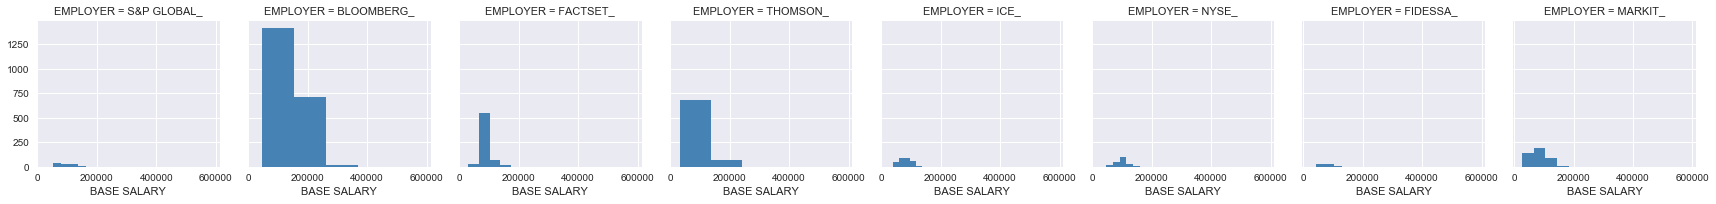

In [27]:
g = sns.FacetGrid(df_, col="EMPLOYER", margin_titles=True)
g.map(plt.hist, "BASE SALARY", color="steelblue", bins=5,lw=0)



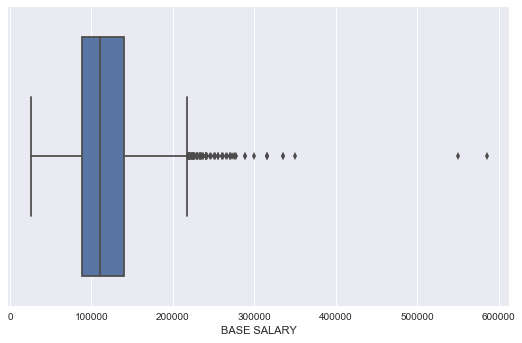

In [28]:
sns.boxplot(x=df_['BASE SALARY'])

(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text xticklabel objects>)

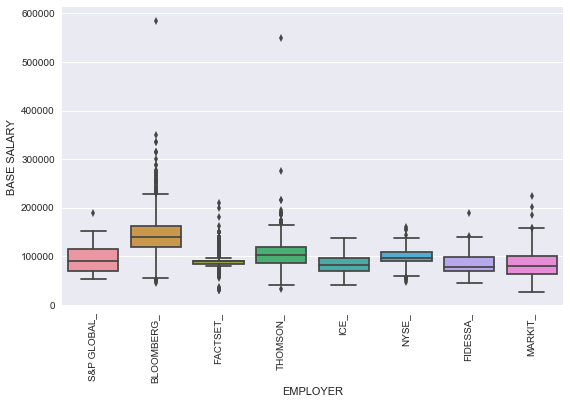

In [29]:
sns.boxplot(x='EMPLOYER', y='BASE SALARY', data=df_)
plt.xticks(rotation=90)

In [30]:
#sns.swarmplot(x='EMPLOYER', y='BASE SALARY', data=df_, color = ".25")

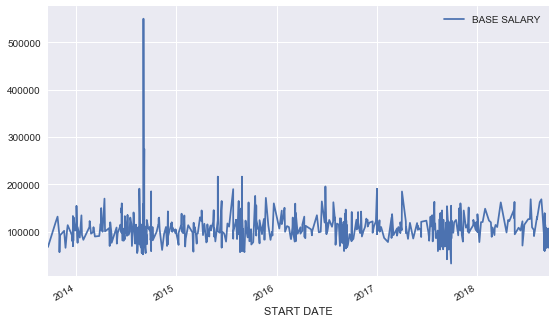

In [31]:
#fix this: crappy time series chart
df_[df_['EMPLOYER']=='THOMSON_'].plot(x='START DATE')

In [32]:
df_.head()

,EMPLOYER,JOB TITLE,BASE SALARY,LOCATION,SUBMIT DATE,START DATE,CASE STATUS,STATE
0,S&P GLOBAL_,ACCOUNT MANAGER,65000,"SAN FRANCISCO, CA",2018-03-13,2018-09-01,CERTIFIED,CA
1,S&P GLOBAL_,ACCOUNT MANAGER,65000,"SAN FRANCISCO, CA",2018-03-19,2018-09-01,CERTIFIED,CA
2,S&P GLOBAL_,ANALYST II,57900,"CHARLOTTESVILLE, VA",2018-02-01,2018-03-02,DENIED,VA
3,S&P GLOBAL_,ANALYST II,57990,"CHARLOTTESVILLE, VA",2018-02-06,2018-03-02,CERTIFIED,VA
4,S&P GLOBAL_,"ANALYST II, INFORMATION SECURITY",85000,"NEW YORK, NY",2017-06-07,2017-10-27,CERTIFIED,NY


In [33]:
df_['START MONTH'] = df_['START DATE'].apply(lambda x: x.month)
df_.head()

,EMPLOYER,JOB TITLE,BASE SALARY,LOCATION,SUBMIT DATE,START DATE,CASE STATUS,STATE,START MONTH
0,S&P GLOBAL_,ACCOUNT MANAGER,65000,"SAN FRANCISCO, CA",2018-03-13,2018-09-01,CERTIFIED,CA,9
1,S&P GLOBAL_,ACCOUNT MANAGER,65000,"SAN FRANCISCO, CA",2018-03-19,2018-09-01,CERTIFIED,CA,9
2,S&P GLOBAL_,ANALYST II,57900,"CHARLOTTESVILLE, VA",2018-02-01,2018-03-02,DENIED,VA,3
3,S&P GLOBAL_,ANALYST II,57990,"CHARLOTTESVILLE, VA",2018-02-06,2018-03-02,CERTIFIED,VA,3
4,S&P GLOBAL_,"ANALYST II, INFORMATION SECURITY",85000,"NEW YORK, NY",2017-06-07,2017-10-27,CERTIFIED,NY,10


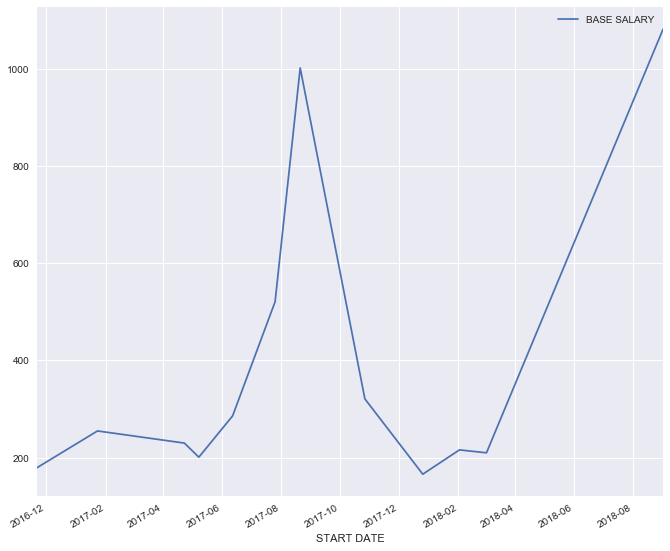

In [34]:
chartdf = df_.groupby('START MONTH').agg({'START DATE': 'first', 'BASE SALARY': 'count'})
chartdf.set_index('START DATE').plot(figsize=(10,10))

 <p><a name="addl"></a></p>
# More Analyses
 <a href="#sections">Top</a>

In [35]:
#filter/sub-set just on a single job description
title = 'FINANCIAL ENGINEER'
position1 = df_[df_['JOB TITLE'] == title]
position1.describe()

,BASE SALARY,START MONTH
count,46.00000,46.00000
mean,95928.73913,8.95652
std,28954.11838,0.91788
min,40500.00000,7.00000
25%,85000.00000,8.00000
50%,90000.00000,9.00000
75%,94291.50000,10.00000
max,230000.00000,10.00000


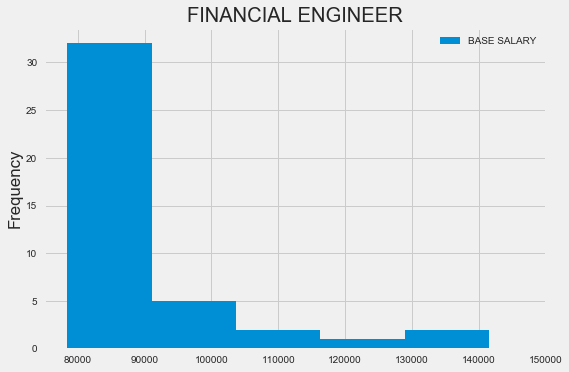

In [36]:
%matplotlib inline
import seaborn as sns
sns.set()
plt.style.use('fivethirtyeight')
plt.xlim(75000,150000)

position1['BASE SALARY'].plot(kind='hist', title = title, legend = True,  bins=15)

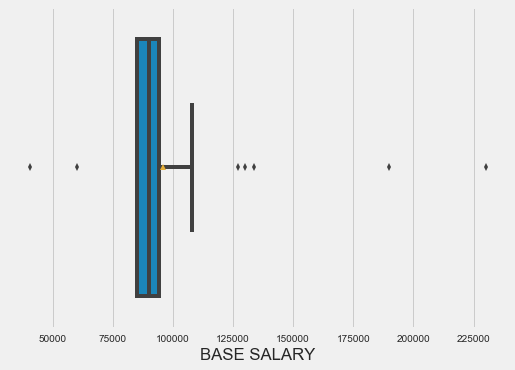

In [37]:
#position1['BASE SALARY'].plot(kind='box', title = title, legend=True)
sns.boxplot(x=position1['BASE SALARY'], showmeans=True)

__Drilldown to firms that employ specific Job Title__

In [38]:
agglist = ('count','mean', 'min', 'max', 'std')

pd.set_option('precision',2)

result1 = position1.pivot_table('BASE SALARY', index = ["EMPLOYER"], aggfunc = agglist)

result1.sort_values('count', ascending=False)
result1

,count,mean,min,max,std
EMPLOYER,,,,,
BLOOMBERG_,8,140277,95722,230000,46166.12
FACTSET_,36,88611,85000,100000,4722.46
ICE_,2,50250,40500,60000,13788.58


# New Fetch: Single Title for all Employers

In [39]:
title = 'Quantitative Analyst'
titlelist = title.split(' ')
len(titlelist)

titlestring = titlelist[0]+ '+'+ titlelist[1]
titlestring
#titlestring = [titlestring.append(titlelist[x]) for x in len(titlelist)]


'Quantitative+Analyst'

In [40]:
baseurl = 'http://h1bdata.info/index.php?em=&job='
tailurl = '&city=&year=All+Years'

url2 = baseurl+titlestring+tailurl
url2

'http://h1bdata.info/index.php?em=&job=Quantitative+Analyst&city=&year=All+Years'

In [41]:
content = requests.get(url2).text

In [42]:
#process the html code
soup = BeautifulSoup(content, "html.parser")
#type(soup)

#go to table body
table = soup.find("tbody")

#fetch Column headers
colnames = [tag.text for tag in soup.find("thead").find_all("th")]  

#cycle through tags and populate df with contents
webtable = pd.DataFrame(
        ((tag.text for tag in lst.find_all("td")) for lst in table.find_all("tr")),
        columns = colnames
    )

In [43]:
webtable.describe()

,EMPLOYER,JOB TITLE,BASE SALARY,LOCATION,SUBMIT DATE,START DATE,CASE STATUS
count,1226,1226,1226,1226,1226,1226,1226
unique,378,1,342,145,560,530,3
top,GOOGLE INC,QUANTITATIVE ANALYST,"150,000","NEW YORK, NY",03/05/2015,09/01/2016,CERTIFIED
freq,89,1226,61,454,22,29,1147


In [44]:
webtable

,EMPLOYER,JOB TITLE,BASE SALARY,LOCATION,SUBMIT DATE,START DATE,CASE STATUS
0,RISK PREMIUM INVESTMENT MANAGEMENT COMPANY LLC,QUANTITATIVE ANALYST,0,",",03/14/2018,09/13/2018,DENIED
1,EDISON SOLAR TECHNOLOGYINC,QUANTITATIVE ANALYST,"40,200","EL MONTE, CA",03/28/2016,09/15/2016,CERTIFIED
2,EDISON SOLAR TECHNOLOGYINC,QUANTITATIVE ANALYST,"44,200","EL MONTE, CA",03/16/2016,09/15/2016,CERTIFIED
3,AIM BIG INC,QUANTITATIVE ANALYST,"47,160","CHICAGO, IL",03/06/2017,09/01/2017,CERTIFIED
4,HI-TECH SOLUTIONS INC,QUANTITATIVE ANALYST,"47,160","CHICAGO, IL",03/08/2017,09/07/2017,CERTIFIED
5,HI-TECH SOLUTIONS INC,QUANTITATIVE ANALYST,"47,160","CHICAGO, IL",03/08/2017,09/07/2017,CERTIFIED
6,AIM BIG INC,QUANTITATIVE ANALYST,"47,160","CHICAGO, IL",09/06/2016,09/06/2016,CERTIFIED
7,AIM BIG INC,QUANTITATIVE ANALYST,"47,160","CHICAGO, IL",09/06/2016,09/06/2016,CERTIFIED
8,AIM BIG INC,QUANTITATIVE ANALYST,"47,700","CHICAGO, IL",03/11/2016,09/01/2016,CERTIFIED
9,AIM BIG INC,QUANTITATIVE ANALYST,"47,700","METTAWA, IL",03/17/2016,09/01/2016,CERTIFIED


In [45]:
#add a column call state
newcol = webtable['LOCATION'].apply(lambda x: x.split(', ') [-1])
webtable['STATE'] = newcol
webtable.tail()

,EMPLOYER,JOB TITLE,BASE SALARY,LOCATION,SUBMIT DATE,START DATE,CASE STATUS,STATE
1221,CITIGROUP GLOBAL MARKETS INC,QUANTITATIVE ANALYST,"250,000","NEW YORK, NY",06/15/2017,10/01/2017,CERTIFIED,NY
1222,HBK NEW YORK LLC,QUANTITATIVE ANALYST,"250,000","NEW YORK, NY",11/03/2015,11/16/2015,CERTIFIED,NY
1223,DW PARTNERS LP,QUANTITATIVE ANALYST,"250,000","NEW YORK, NY",06/17/2015,09/18/2015,CERTIFIED,NY
1224,BLOOMBERG LP,QUANTITATIVE ANALYST,"252,000","NEW YORK, NY",10/31/2016,04/30/2017,CERTIFIED,NY
1225,CITIGROUP GLOBAL MARKETS INC,QUANTITATIVE ANALYST,"300,000","NEW YORK, NY",04/05/2017,07/25/2017,CERTIFIED,NY


In [46]:
webtable['BASE SALARY'] = webtable['BASE SALARY'].str.replace(',','').astype(int)

In [47]:
agglist = ('count','mean', 'min', 'max')

pd.set_option('precision',4)

#temp3 = df_.pivot_table('BASE SALARY', index = ["STATE", "EMPLOYER"], aggfunc = agglist)
result2 = webtable.pivot_table('BASE SALARY',index = ['STATE'], aggfunc = agglist)

In [48]:
result2.reindex()
result2

,count,mean,min,max
STATE,,,,
,1,0.0000,0,0
AZ,2,94690.0000,89380,100000
CA,155,112111.4194,40200,180000
CO,2,96477.0000,67954,125000
CT,20,119048.5500,50000,220000
DC,3,77621.3333,58864,90000
DE,3,49946.6667,46000,56000
FL,19,75819.4737,47010,145000
GA,23,65192.0435,44000,125000


In [49]:
result2.sort_values('count', ascending=False)
result2

,count,mean,min,max
STATE,,,,
,1,0.0000,0,0
AZ,2,94690.0000,89380,100000
CA,155,112111.4194,40200,180000
CO,2,96477.0000,67954,125000
CT,20,119048.5500,50000,220000
DC,3,77621.3333,58864,90000
DE,3,49946.6667,46000,56000
FL,19,75819.4737,47010,145000
GA,23,65192.0435,44000,125000


<a href="#sections">Top</a>